In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

dataframe = pd.read_excel(io.BytesIO(uploaded['data2.xlsx']))

KeyboardInterrupt: ignored

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch


# Let's assume that the second column is the target and the rest are the features
# We exclude the first column (date)
data = dataframe.iloc[:, 1:].values

# Scale your data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare your data with some function, e.g., create_dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  # All columns including the target
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # The target column
    return np.array(X), np.array(Y)

# Create the dataset
look_back = 3  # Number of previous time steps to use as input variables to predict the next time period
x, y = create_dataset(data, look_back)

# Determine the number of time periods to allocate as the test set (24 months for 2 years)
test_periods = 12

# Calculate the index to split the data
split_index = len(x) - test_periods 

# Split the data into train and test sets
x_train, x_test = x[:split_index, :], x[split_index:, :]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

def build_model(hp):
    model = Sequential()

    # Tune the number of units in the LSTM layers
    hp_units = hp.Int('units', min_value=64, max_value=256, step=16)
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=hp_units, return_sequences=True))


    model.add(LSTM(units=hp_units, return_sequences=True))
    model.add(LSTM(units=hp_units, return_sequences = False))

    model.add(Dense(1))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.00001])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define early stopping with patience=20 (or any other value you choose)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Define Keras Tuner random search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,
    executions_per_trial=2,
    directory='my_dir',
    project_name='helloworld'
)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=2)

# Evaluate the model on the test set
test_loss = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)





Epoch 1/500
8/8 - 8s - loss: 0.1724 - val_loss: 0.0145 - 8s/epoch - 982ms/step
Epoch 2/500
8/8 - 0s - loss: 0.0426 - val_loss: 0.1052 - 80ms/epoch - 10ms/step
Epoch 3/500
8/8 - 0s - loss: 0.0308 - val_loss: 0.0266 - 89ms/epoch - 11ms/step
Epoch 4/500
8/8 - 0s - loss: 0.0129 - val_loss: 0.0157 - 76ms/epoch - 10ms/step
Epoch 5/500
8/8 - 0s - loss: 0.0088 - val_loss: 0.0187 - 80ms/epoch - 10ms/step
Epoch 6/500
8/8 - 0s - loss: 0.0072 - val_loss: 0.0158 - 82ms/epoch - 10ms/step
Epoch 7/500
8/8 - 0s - loss: 0.0057 - val_loss: 0.0223 - 84ms/epoch - 10ms/step
Epoch 8/500
8/8 - 0s - loss: 0.0056 - val_loss: 0.0147 - 81ms/epoch - 10ms/step
Epoch 9/500
8/8 - 0s - loss: 0.0043 - val_loss: 0.0174 - 79ms/epoch - 10ms/step
Epoch 10/500
8/8 - 0s - loss: 0.0039 - val_loss: 0.0105 - 81ms/epoch - 10ms/step
Epoch 11/500
8/8 - 0s - loss: 0.0038 - val_loss: 0.0106 - 82ms/epoch - 10ms/step
Epoch 12/500
8/8 - 0s - loss: 0.0036 - val_loss: 0.0111 - 77ms/epoch - 10ms/step
Epoch 13/500
8/8 - 0s - loss: 0.0034 -

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1, 32)             1184      
                                                                 
 lstm_20 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_21 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_22 (LSTM)              (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26,177
Trainable params: 26,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 1s 1s/step
[[0.69899786]
 [0.72422886]
 [0.7631487 ]
 [0.9298353 ]
 [0.9147129 ]
 [0.7285106 ]
 [0.753743  ]
 [0.7805297 ]
 [0.9667583 ]
 [0.9973455 ]
 [0.793773  ]
 [0.75671655]]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# 평균 제곱근 오차(RMSE) 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# 평균 절대 오차(MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

RMSE: 0.03372720901713535
MAE: 0.02736146310649863
MAPE: 0.03250720731755345


In [ ]:
from sklearn.metrics import r2_score

# 결정 계수를 계산합니다.
r2 = r2_score(y_test, y_pred)

# 결정 계수를 출력합니다.
print("R^2 Score:", r2)

R^2 Score: 0.9173920137315585


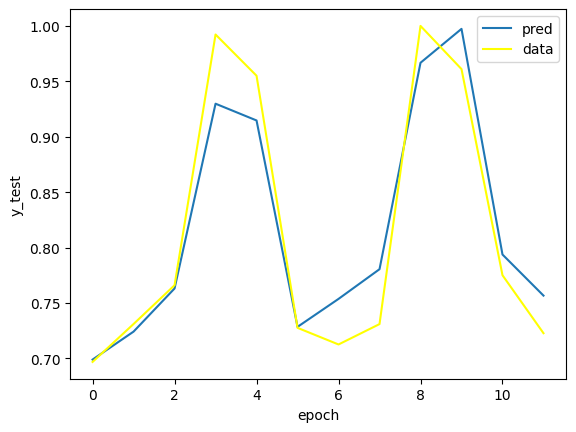

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(y_pred, label='pred')
plt.plot(y_test, label='data',color = 'yellow')
plt.ylabel('y_test')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
